# Neural Network for <em> well Log</em> Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn import datasets, metrics, model_selection


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

log_folder = "logs/ANN/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [3]:
# read data

xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 5s')
dataset= df.copy()

#### Split the data into train and test

In [4]:
# the 'sample' method takes a certain fraction randomly
#Note that we use `random_state` to ensure the reproducibility of the examples.
train_dataset = dataset.sample(frac=0.7, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [5]:

# split datat into input and target

train_input = train_dataset.copy()
test_input = test_dataset.copy()

train_target = train_input.pop('RHOB')
test_target = test_input.pop('RHOB')



 normalizer = preprocessing.Normalization()

 #then adapt it to the data
 normalizer.adapt(np.array(train_input))

  #This calculates the mean and variance, and stores them in the layer.
 print(normalizer.mean.numpy())

# Create Model

In [ ]:
#     #  Create layers
#     l0=normalizer
#     #Dense layers using the relu nonlinearity. #with an l2 regularization to reduce overfitting by reducing weight size
#     l1=tf.keras.layers.Dense(64,activation="relu", input_shape=(5,), kernel_regularizer="l2")
    
#     d0=layers.Dropout(0.1), #a droput layer # an attempt to reduce overfitting
    
#     l2=tf.keras.layers.Dense(64,activation="relu", kernel_regularizer="l2")
    
#     d1=layers.Dropout(0.1),
    
#     #A linear output layer
#     l3=tf.keras.layers.Dense(1)
    
    
# #     create the model with the layers formed
#     model1 =tf.keras.models.Sequential([l0,l1,d0,l2,d1,l3])

In [21]:
# A function to hold preprocessor, layers, model and compiler 
def FFBackProp(inputs, output):
   

    #normalization
    normalizer=preprocessing.Normalization()
    #then adapt it to the data
    normalizer.adapt(np.array(inputs))
    
    
    model1 = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation="relu", input_shape=(5,), 
#                           kernel_regularizer="l2"
                         ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation="relu",
#                           kernel_regularizer="l2"
                         ),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
  ])
    
    
#     compile the model
    model1.compile(optimizer='adam',
                loss='mean_absolute_error', #(from_logits=True),
                metrics=["mse"]
               )
    
    model1.summary()
    
    return model1
    
myFFBP= FFBackProp(train_input,train_target)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                192       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

# Training

In [22]:
%%time
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir="log_folder/ANN", histogram_freq=1)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder,
                                            histogram_freq=1,
                                            write_graph=True,
                                            write_images=True,
                                            update_freq='epoch',
                                            profile_batch=2,
                                            embeddings_freq=1)


myFFBPtraining = myFFBP.fit(
    train_input, train_target,
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     
    
    validation_data=(test_input, test_target),
    
    
    # suppress logging
    verbose=0,
    
    epochs=100,
    

    #early stopping
    #an attempt to prevent overfitting
    #the fuction to stop the trianing by tracking the validation loss
    #callbacks= keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
    
    #to store callbacks in logs
#     callbacks =[tb_callback]
)

Wall time: 7.81 s


In [23]:
myFFBP.evaluate(test_input, test_target,
                callbacks=[tb_callback],
                verbose=0, )

[0.11330290138721466, 0.03158975765109062]

In [11]:

hist = pd.DataFrame(myFFBPtraining.history)
hist['epoch'] = myFFBPtraining.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,0.183338,0.063035,0.158064,0.032727,95
96,0.176386,0.045857,0.158215,0.030247,96
97,0.173623,0.038173,0.154586,0.031825,97
98,0.171547,0.037689,0.152107,0.031166,98
99,0.169529,0.037310,0.161730,0.036418,99


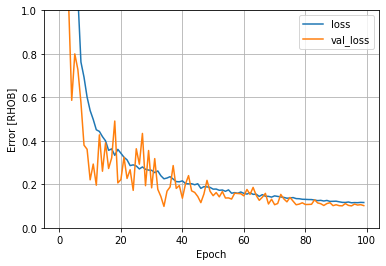

In [17]:
# a function to plot loss 
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(myFFBPtraining)

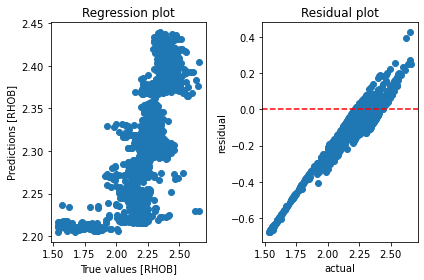

In [12]:
# Plot regression between predicted and actual (Validation)
# test_predictions = dnn_model.predict(test_input).flatten()


def plot_regre_resid(true, predicted):
    fig, (ax1,ax2)=plt.subplots(1,2)
    ax1.scatter(true, predicted)
    ax1.set_xlabel('True values [RHOB]')
    ax1.set_ylabel('Predictions [RHOB]')
    ax1.set_title("Regression plot")
#     _ = ax1.plot([0, true.max()], [0, true.max()], ls='-', color='red')

    residual = true - predicted
    ax2.scatter(true, residual)
    ax2.set_xlabel('actual')
    ax2.set_ylabel('residual')
    ax2.set_title("Residual plot")
    _ = plt.axhline(0, color='red', ls='--')
        
    plt.tight_layout()
    plt.show
    
        

test_target_actual=test_target

test_target_predicted = myFFBP.predict(test_input).flatten()
plot_regre_resid(test_target_actual,test_target_predicted)

In [ ]:

def plot_residual_KDE(true, predicted):
    residual = true - predicted
    _ = sns.displot(residual, kind="kde");
    
    
plot_residual_KDE(test_target_actual,test_target_predicted)

In [ ]:
# using sklearn
print("r2 score: {}".format(metrics.r2_score(test_target_actual, test_target_predicted)))
print("mse: {}".format(metrics.mean_squared_error(test_target_actual, test_target_predicted)))
print("rmse: {}".format(np.sqrt(metrics.mean_squared_error(test_target_actual, test_target_predicted))))
print("mae: {}".format(metrics.mean_absolute_error(test_target_actual, test_target_predicted)))

# Predict a different well

In [ ]:
# read different sheet from same excel book
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 4s')
dataset2= df.copy()


# split data into input and target

inputs2 = dataset2.copy()
target2 = inputs2.pop('RHOB')

In [ ]:
predicted2 = myFFBP.predict(inputs2, callbacks=[tb_callback] )
fig, ax= plt.subplots()
ax.scatter(target2,predicted2)
ax.set_xlabel("True")
ax.set_ylabel("predicted")

In [ ]:
print("r2 score: {}".format(metrics.r2_score( target2, predicted2)))
print("mse: {}".format(metrics.mean_squared_error( target2, predicted2)))
print("rmse: {}".format(np.sqrt(metrics.mean_squared_error( target2, predicted2))))
print("mae: {}".format(metrics.mean_absolute_error( target2, predicted2)))

In [ ]:
#plot subplots of predicted and actual
inputs2 = dataset2.copy()
Depth2= inputs2.pop("DEPTH")


fig, (ax1,ax2,ax3)=plt.subplots(1,3,sharey=True)
fig.suptitle('A comparism of the predicted against the actual')
ax1.set_ylabel("Depth")
ax1.plot(predicted2,Depth2)
ax1.set_xlabel('predicted2')

ax2.plot(target2,Depth2)
ax2.set_xlabel("target2")

ax3.plot(predicted2,Depth2)
ax3.plot(target2, Depth2)
ax3.set_xlabel("RHOB")

In [ ]:
rm -rvf logs

# TENSORBOARD VISUALISATION


In [ ]:
# Load the tensorboard
%tensorboard --logdir logs/ANN/fit/ --host localhost
# !kill 25184
# %tensorboard -- logdir={log_folder}

# %tensorboard --logdir /cont